In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle
import seaborn as sns

from neurals.nn import DataSynthesizer
from neurals.transformer import DataTransformer
        
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/final_dataset.csv')

In [3]:
data = pd.DataFrame()

In [4]:
data = df[['33b_cur', '33b_orig_ord_amt']]

In [5]:
conditions = [
    df['50f_payor_add_lon'] != "",
    df["50k_payor_address_lon"] != ""]
choices = [df["50f_payor_add_lon"], df["50k_payor_address_lon"]]
data['src_lon'] = np.select(conditions, choices, default=0)

In [6]:
conditions = [
    df["50f_payor_add_lat"] != "",
    df["50k_payor_address_lat"] != ""]
choices = [df["50f_payor_add_lat"], df["50k_payor_address_lat"]]
data["src_lat"] = np.select(conditions, choices, default=0)

In [7]:
data[["target_lat", "target_lon"]] = df.loc[:, ["59f_ben_add_lat", "59f_ben_add_lon"]]

In [8]:
data["charge_dtls"] = df.loc[:, "71A_chg_dtls"]

In [9]:
data[["charge_dtls_cur", "charge_dtls_amt"]] = df.loc[:, ["71f_chg_dtls_cur", "71f_chg_dtls_amt"]]

In [10]:
data

,33b_cur,33b_orig_ord_amt,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,1544103.68,NaN,NaN,34.146942,-118.247847,SHA,NaN,NaN
1,RUB,912070.95,NaN,NaN,47.566422,-99.650882,BEN,RUB,0.0
2,RUB,21760302.59,NaN,NaN,42.795605,-110.929451,SHA,NaN,NaN
3,RUB,878587.53,NaN,NaN,35.815612,-101.910435,SHA,NaN,NaN
4,RUB,6696355.97,NaN,NaN,27.547259,-81.811471,SHA,NaN,NaN
...,...,...,...,...,...,...,...,...,...
379521,USD,8339.00,NaN,NaN,37.653540,-122.416866,SHA,NaN,NaN
379522,USD,4001.56,-96.707775,40.808886,39.793896,-74.223206,BEN,USD,0.0
379523,USD,4456.00,-81.822065,37.941215,39.808320,-104.933868,OUR,NaN,NaN
379524,USD,8836.10,NaN,NaN,40.366432,-105.502855,SHA,NaN,NaN


In [11]:
data["charge_dtls_cur"] = data["charge_dtls_cur"].replace(np.nan, "999", regex=True)
data["charge_dtls_amt"] = data["charge_dtls_amt"].replace(np.nan, 0, regex=True)

data["target_lat"] = data["target_lat"].replace(np.nan, 0, regex=True)
data["target_lon"] = data["target_lon"].replace(np.nan, 0, regex=True)
data["src_lon"] = data["src_lon"].replace(np.nan, 0, regex=True)
data["src_lat"] = data["src_lat"].replace(np.nan, 0, regex=True)

In [12]:
data.columns

Index(['33b_cur', '33b_orig_ord_amt', 'src_lon', 'src_lat', 'target_lat',
       'target_lon', 'charge_dtls', 'charge_dtls_cur', 'charge_dtls_amt'],
      dtype='object')

In [13]:
data

,33b_cur,33b_orig_ord_amt,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,1544103.68,0.000000,0.000000,34.146942,-118.247847,SHA,999,0.0
1,RUB,912070.95,0.000000,0.000000,47.566422,-99.650882,BEN,RUB,0.0
2,RUB,21760302.59,0.000000,0.000000,42.795605,-110.929451,SHA,999,0.0
3,RUB,878587.53,0.000000,0.000000,35.815612,-101.910435,SHA,999,0.0
4,RUB,6696355.97,0.000000,0.000000,27.547259,-81.811471,SHA,999,0.0
...,...,...,...,...,...,...,...,...,...
379521,USD,8339.00,0.000000,0.000000,37.653540,-122.416866,SHA,999,0.0
379522,USD,4001.56,-96.707775,40.808886,39.793896,-74.223206,BEN,USD,0.0
379523,USD,4456.00,-81.822065,37.941215,39.808320,-104.933868,OUR,999,0.0
379524,USD,8836.10,0.000000,0.000000,40.366432,-105.502855,SHA,999,0.0


In [14]:
discrete = [col for col in data.columns if col not in data._get_numeric_data().columns]

In [15]:
xfm_datafile = "data/xfm_datafile.csv"
xfm_model = "models/gan_transformer.pkl"
reload_data = False

In [28]:
%%time
if reload_data:
    transformer = DataTransformer()
    transformer.fit(data, discrete)
    data_ = transformer.transform(data)
    pd.DataFrame(data_).to_csv(xfm_datafile)
    pickle.dump(transformer, open(xfm_model, 'wb'))
else:
    data_ = pd.read_csv(xfm_datafile).to_numpy()
    transformer = pickle.load(open(xfm_model, 'rb'))

CPU times: user 3.64 s, sys: 300 ms, total: 3.94 s
Wall time: 3.95 s


In [52]:
synthesizer = DataSynthesizer(epochs = 10, verbose = True, pac = 1, 
                              option = 'cnn', num_filters = [10, 10, 10, 10, 10], 
                              filter_sizes = [2, 3, 4, 5, 6],
                              xfm_indicator = True, transformer = transformer, 
                              xfm_datafile = xfm_datafile)

Initializing synthesizer !!
[[SpanInfo(dim=33, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=5, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=7, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=7, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=9, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=8, activation_fn='softmax')], [SpanInfo(dim=3, activation_fn='softmax')], [SpanInfo(dim=34, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=1, activation_fn='softmax')]]


In [53]:
%%time
synthesizer.fit(data, discrete)

Tranformer indicator is True
Loading data from data/xfm_datafile.csv
Instantiating discriminator with cnn layer as first set of layers !
DiscriminatorC(
  (conv1d_list): ModuleList(
    (0): Conv1d(70, 10, kernel_size=(2,), stride=(1,))
    (1): Conv1d(70, 10, kernel_size=(3,), stride=(1,))
    (2): Conv1d(70, 10, kernel_size=(4,), stride=(1,))
    (3): Conv1d(70, 10, kernel_size=(5,), stride=(1,))
    (4): Conv1d(70, 10, kernel_size=(6,), stride=(1,))
  )
  (seq): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)
Starting training epochs. Number of epochs : 10
Epoch 1, Loss G:  3.8741,Loss D: -4.9820
Epoch 2, Loss G:  0.8101,Loss D: -1.1710
Epoch 3, Loss G:  3.3788,Loss D: -1.6068
E

In [54]:
num_samples = 300000

In [55]:
%%time
samples = synthesizer.sample(num_samples)

CPU times: user 4min 49s, sys: 288 ms, total: 4min 50s
Wall time: 1min 13s


In [56]:
def corrplot(data, samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(data.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")
    
    plt.subplot(122)
    sns.heatmap(samples.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")

In [57]:
def attr_plot(data, samples):
    
    numerical_columns = data._get_numeric_data().columns
    discrete_columns = [col for col in data.columns if col not in numerical_columns]
    
    for col in data.columns:
        if col not in discrete_columns:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.distplot(data[col], bins=100, hist_kws={'alpha': 0.7})
            plt.subplot(122)
            sns.distplot(samples[col], bins=100, hist_kws={'alpha': 0.7})
        else:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.countplot(x=col, data=data)
            plt.xticks(rotation=45)
            plt.subplot(122)
            sns.countplot(x=col, data=samples)
            plt.xticks(rotation=45)

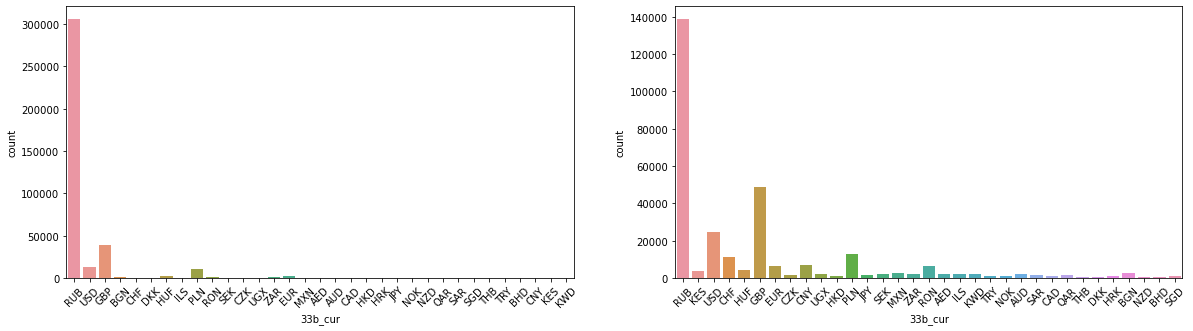

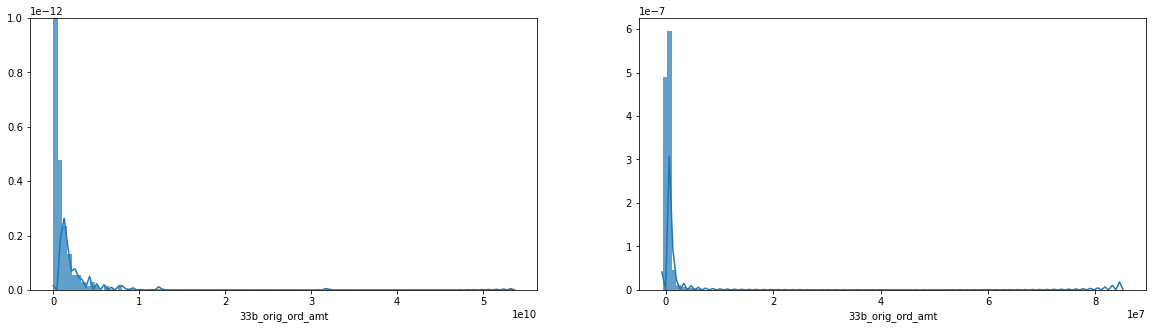

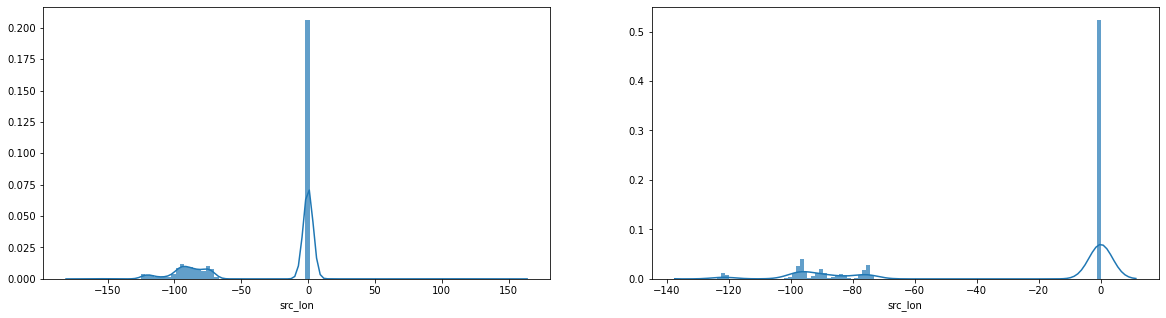

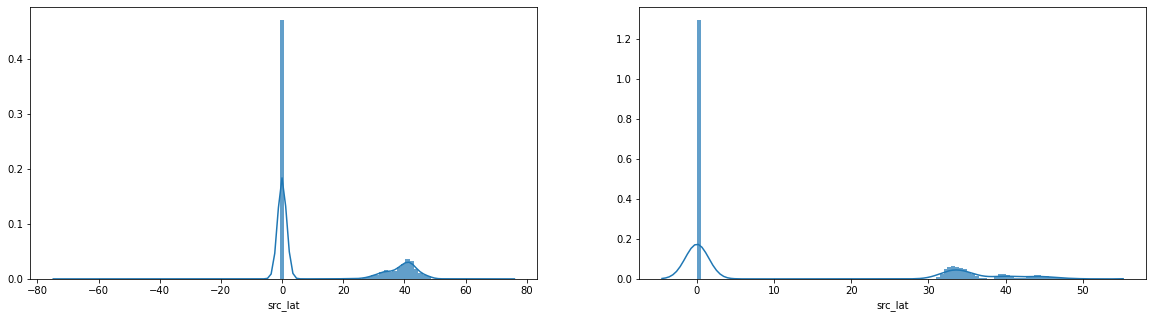

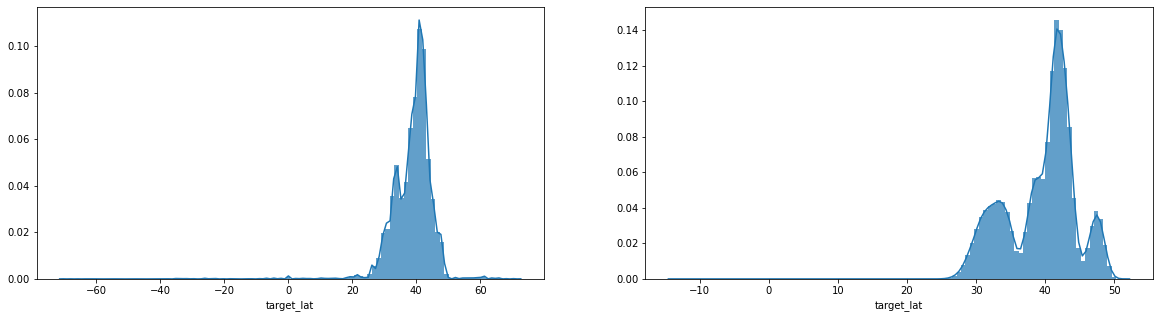

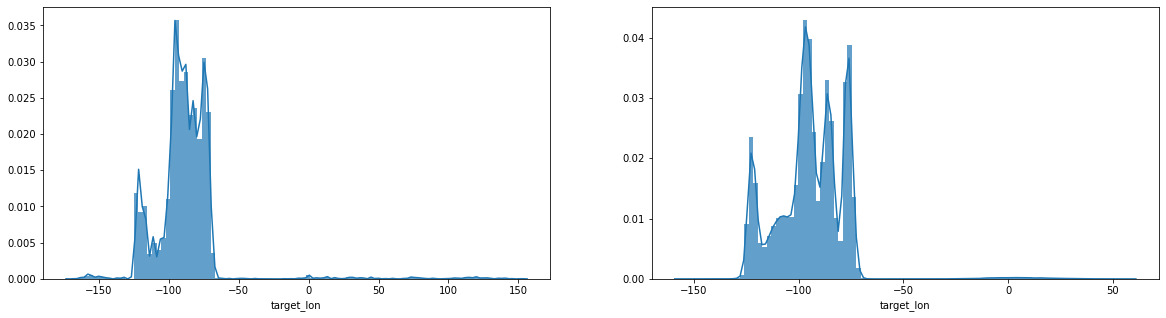

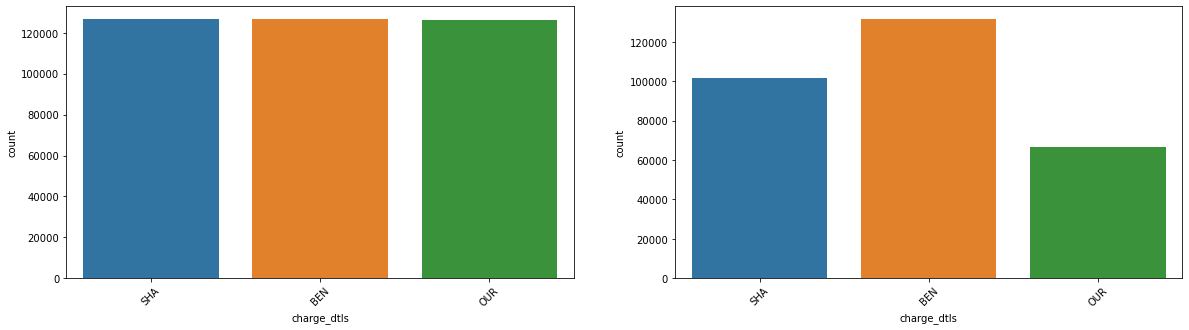

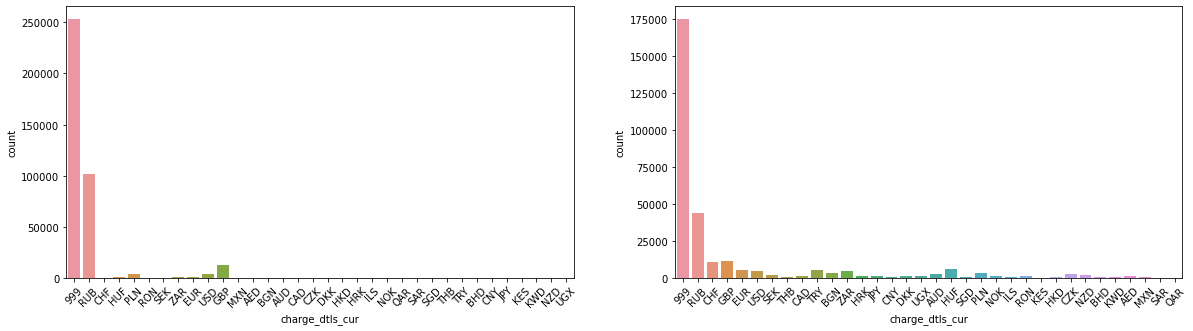

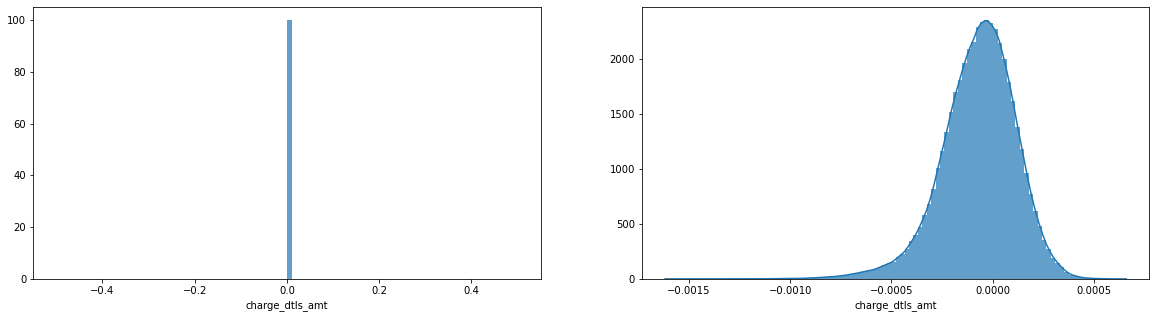

In [58]:
attr_plot(data, samples)

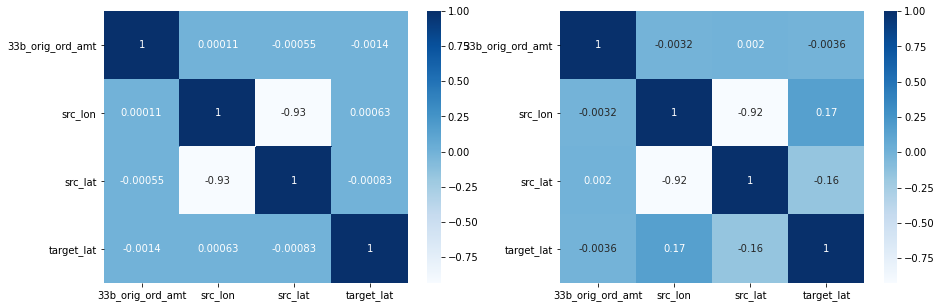

In [59]:
corrplot(data, samples)

In [60]:
# transformer = DataTransformer()

In [65]:
numerical_columns = data._get_numeric_data().columns
discrete_columns = [col for col in data.columns if col not in numerical_columns]

In [62]:
# %%time 
# transformer.fit(data, discrete_columns)

In [63]:
# %%time
# data_ = transformer.transform(data)

In [68]:
data_.shape

(379526, 113)

In [54]:
cov_samples = new_samples[0].T.dot(new_samples[0])
Us, ss, Vts = np.linalg.svd(cov_samples)

In [73]:
cov_data = data_.T.dot(data_)
Ud, sd, Vtd = np.linalg.svd(cov_data)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

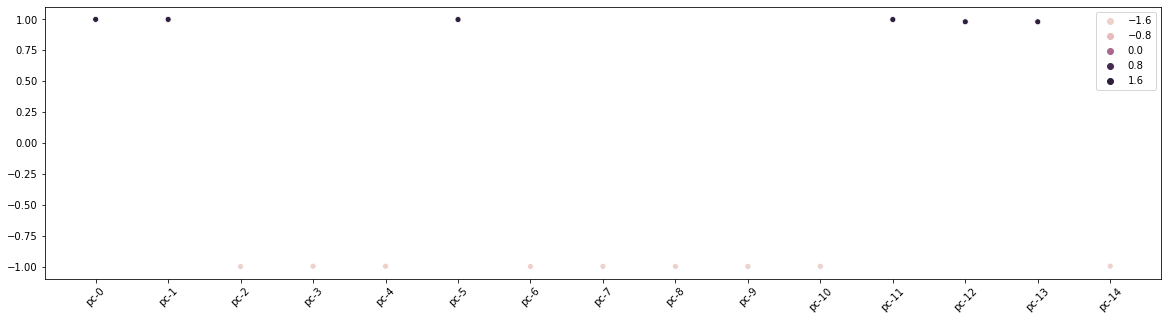

In [87]:
n_components = 15
x = ['pc-'+str(i) for i in range(n_components)]
y = [Us[:, i].dot(Ud[:, i]) for i in range(n_components)]

plt.figure(figsize=(20, 5))
sns.scatterplot(x, y, hue=y)
plt.xticks(rotation=45)
# for i, txt in enumerate(range(10)):
#     plt.annotate(txt, (x[i], y[i]))

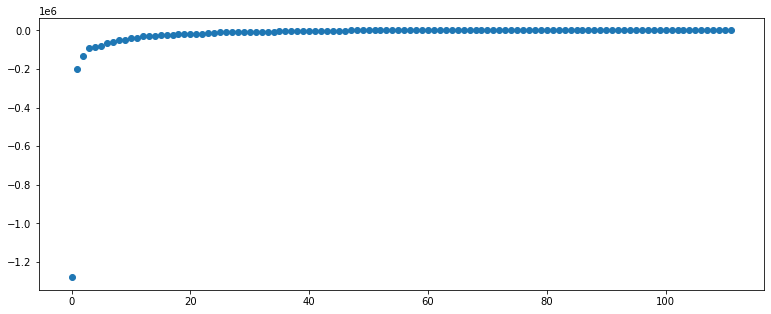

In [61]:
plt.figure(figsize=(13, 5))
plt.scatter(range(Us.shape[1]), ss - sd)

In [70]:
%%time
samples_xfm = transformer.transform(samples)

CPU times: user 1min 13s, sys: 6.08 s, total: 1min 19s
Wall time: 1min 10s


In [71]:
cov_samples = samples_xfm.T.dot(samples_xfm)
Us, ss, Vts = np.linalg.svd(cov_samples)

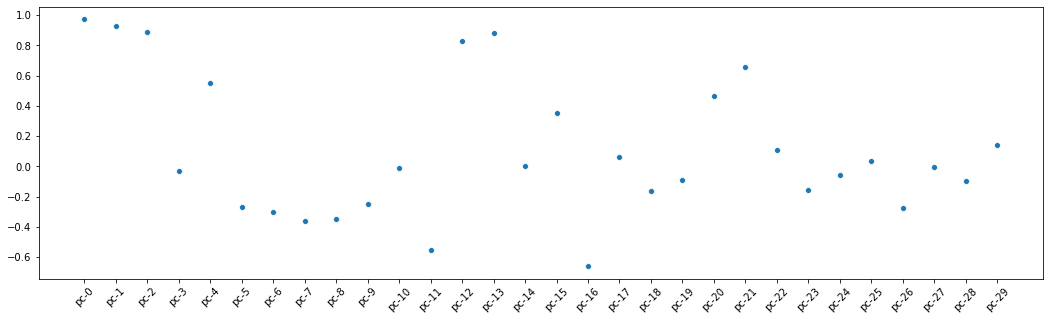

In [76]:
n_components = 30
x = ['pc-'+str(i) for i in range(n_components)]
y = [Us[:, i].dot(Ud[:, i]) for i in range(n_components)]

plt.figure(figsize=(18, 5))
sns.scatterplot(x, y)
plt.xticks(rotation=45)
plt.show()
# for i, txt in enumerate(range(10)):
#     plt.annotate(txt, (x[i], y[i]))

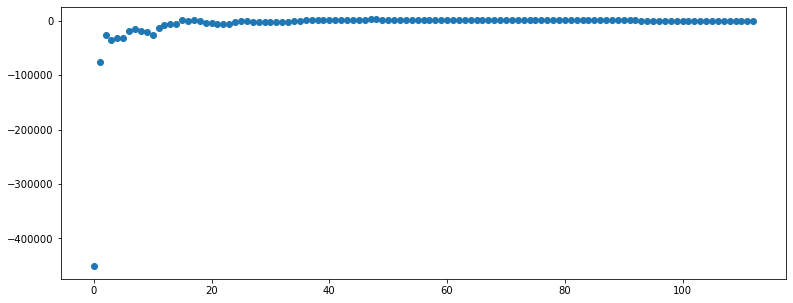

In [77]:
plt.figure(figsize=(13, 5))
plt.scatter(range(Us.shape[1]), ss - sd)
plt.show()

In [80]:
from sklearn.mixture import GaussianMixture as GMM

In [81]:
%%time
gmm = GMM(n_components = 10, covariance_type = "full", random_state = 0).fit(samples_xfm)

CPU times: user 6min 16s, sys: 2min 10s, total: 8min 27s
Wall time: 2min 39s


In [85]:
%%time
samples_labels = gmm.predict(samples_xfm)

CPU times: user 10.1 s, sys: 5.34 s, total: 15.4 s
Wall time: 5.11 s


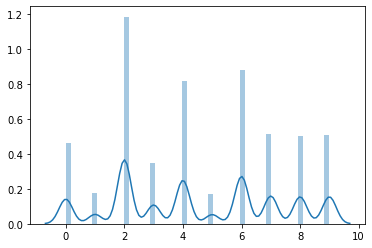

In [94]:
sns.distplot(samples_labels)

In [95]:
%%time
gmm_data = GMM(n_components = 10, covariance_type = "full", random_state = 0).fit(data_)

CPU times: user 11min 51s, sys: 3min 42s, total: 15min 33s
Wall time: 5min 22s


In [193]:
%%time
data_labels = gmm_data.predict(data_)

CPU times: user 12 s, sys: 6.14 s, total: 18.2 s
Wall time: 6.53 s


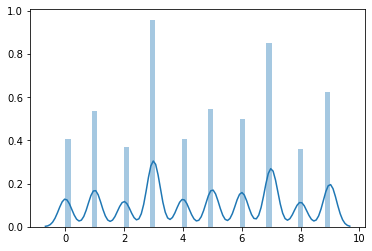

In [194]:
sns.distplot(data_labels)

In [195]:
v_ = pd.DataFrame(data_labels).value_counts()
z_ = np.array([v_.to_dict()[x]/v_.sum() for x in v_.to_dict().keys()])

In [196]:
vs_ = pd.DataFrame(samples_labels).value_counts()
zs_ = np.array([vs_.to_dict()[x]/vs_.sum() for x in vs_.to_dict().keys()])

In [197]:
import scipy
import sklearn

scipy.special.kl_div(z_, zs_).sum()

0.039120440402699797

In [198]:
sklearn.metrics.mutual_info_score(z_, zs_)

2.302585092994046

In [199]:
scipy.stats.entropy(z_, zs_)

0.03912044040269978